In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf
import os, sys

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/FearConditioning_Data.pkl"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
LPNE_PATH = "/work/mk423/lpne-data-analysis"
sys.path.append(LPNE_PATH)

import data_tools

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"

feature_list = ["X_psd","X_coh","X_gc"]
feature_weights = [10,1,1]

group_1_mice = [
"Mouse04191",
"Mouse04201",
"Mouse04203",
"Mouse04215",
"Mouse3203",
"Mouse3223",
"Mouse39114",
"Mouse39121",
"Mouse39124",
"Mouse39133",
"Mouse9001",
"Mouse9011",
"Mouse9013",
"Mouse9022",
"Mouse9071",
"Mouse9072",
"Mouse9084",
]

group_2_mice = [
"Mouse04193",
"Mouse04202",
"Mouse04211",
"Mouse04213",
"Mouse3205",
"Mouse3235",
"Mouse3252",
"Mouse39122",
"Mouse39125",
"Mouse39132",
"Mouse39135",
"Mouse9002",
"Mouse9003",
"Mouse9021",
"Mouse9065",
"Mouse9074",
]

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
print(len(group_1_mice) + len(group_2_mice))

33


In [5]:
X_psd, X_coh, X_gc, labels = data_tools.load_data("/work/mk423/Anxiety/FC_tone_events.mat",feature_list = ["power","coherence","granger"])

version saveFeatures_1.2 used to calcuate power features
version saveFeatures_1.2 used to calcuate coherence features
version saveFeatures_1.2 used to calcuate granger features
Version preprocessData_1.0 of preprocessing used
Make sure feature versions listed above match those used for any other dataset in the same project


/work/mk423/lpne-data-analysis/data_tools.py:144: UserWarning: Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself
  warnings.warn("Raw Granger causality values loaded; if you want exponentiated or capped features, you must do that yourself")


In [48]:
np.unique(y_mouse,return_counts=True)

(array(['Mouse39114', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39124', 'Mouse39125', 'Mouse39132', 'Mouse39133',
        'Mouse39135', 'Mouse9001', 'Mouse9002', 'Mouse9003', 'Mouse9011',
        'Mouse9013', 'Mouse9021', 'Mouse9022', 'Mouse9061', 'Mouse9065',
        'Mouse9071', 'Mouse9072', 'Mouse9074', 'Mouse9075', 'Mouse9084'],
       dtype='<U10'),
 array([149, 148, 150, 148, 148, 149, 150, 150, 150, 144, 129,  34, 135,
        140,  76, 103, 146, 136, 140, 148, 146, 150, 150]))

In [67]:
X = np.hstack([X_psd*10,X_coh,X_gc])
y_time = np.array(labels['windows']['time'])
y_mouse = np.array(labels['windows']['mouse'])
s = model.project(X)
coeffs = model.classifier[0].weight[0].detach().cpu().numpy()

s_agg = s[:,:3] @ coeffs

In [80]:
for net in range(4):
    
    if net == 3:
        s_agg = s[:,:3] @ coeffs

    else:
        s_agg = s[:,net]
        
    all_slices_g1 = []
    mouse_ids_g1 = []

    all_slices_g2 = []
    mouse_ids_g2 = []
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        if np.sum(mouse_mask) > 120:
            time_slice = y_time[mouse_mask==1]

            temp_array = np.zeros(150)*np.nan
            temp_array[time_slice-1] = s_agg[mouse_mask==1]

            if mouse in group_1_mice:
                all_slices_g1.append(temp_array)
                mouse_ids_g1.append(mouse)
            else:
                all_slices_g2.append(temp_array)
                mouse_ids_g2.append(mouse)

    all_slices_g1 = np.array(all_slices_g1)
    mouse_ids_g1 = np.array(mouse_ids_g1)

    all_slices_g2 = np.array(all_slices_g2)
    mouse_ids_g2 = np.array(mouse_ids_g2)

    g1_projection = np.hstack((mouse_ids_g1.reshape(-1,1).astype(object),
                               np.array(["group_1" for mouse in mouse_ids_g1]).reshape(-1,1).astype(object),
                               all_slices_g1.astype(object)))

    g2_projection = np.hstack((mouse_ids_g2.reshape(-1,1).astype(object),
                               np.array(["group_2" for mouse in mouse_ids_g2]).reshape(-1,1).astype(object),
                               all_slices_g2.astype(object)))

    projection = np.vstack((g1_projection,g2_projection))
    df = pd.DataFrame(projection)
    df.columns = np.hstack((["Mouse","Group"],np.arange(150) - 30))
    if net < 3:
        df.to_csv(PROJECT_PATH + "Fear_Tone_30b120a_net_{}.csv".format(net))
    else:
        df.to_csv(PROJECT_PATH + "Fear_Tone_30b120a_agg_net.csv")


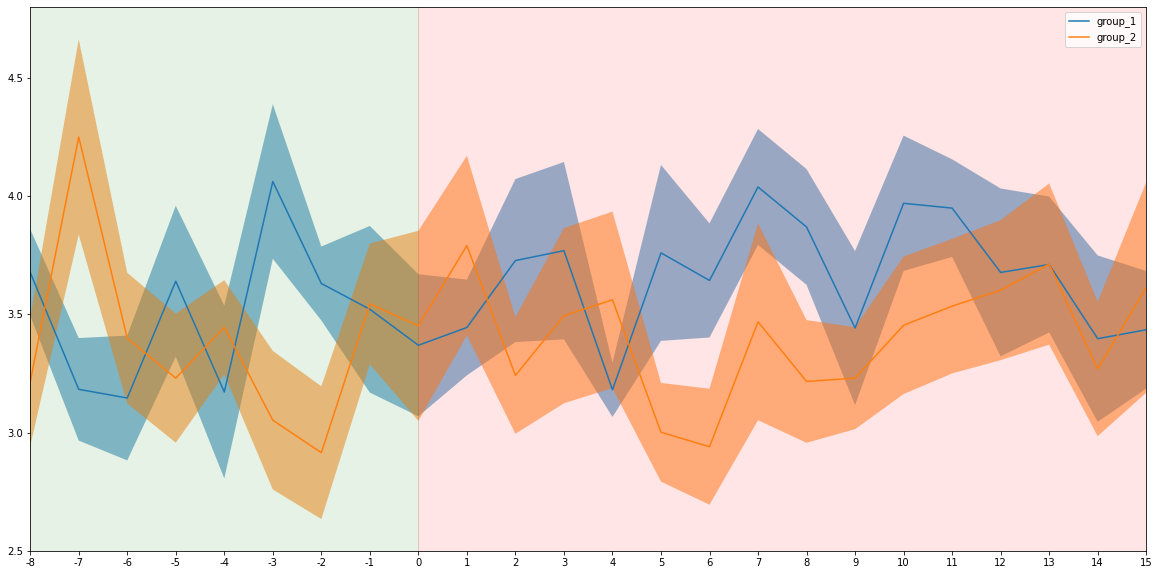

In [69]:
plt.figure(figsize=(20,10))

g1_mean = np.nanmean(all_slices_g1,axis=0)
g2_mean = np.nanmean(all_slices_g2,axis=0)

g1_sterr = np.nanstd(all_slices_g1,axis=0) / np.sqrt(all_slices_g1.shape[0])
g2_sterr = np.nanstd(all_slices_g2,axis=0) / np.sqrt(all_slices_g2.shape[0])

plt.plot(g1_mean,label="group_1")
plt.plot(g2_mean,label="group_2")

plt.fill_between(np.arange(150), g1_mean + g1_sterr, g1_mean - g1_sterr,alpha=0.5)
plt.fill_between(np.arange(150), g2_mean + g2_sterr, g2_mean - g2_sterr,alpha=0.5)

plt.fill_between(np.arange(31),0,5,color="green",alpha=0.1)
plt.fill_between(np.arange(30,150),0,5,color="red",alpha=0.1)
#plt.axvline(30,color="red")

plt.xticks(np.arange(150),np.arange(150) - 30)
plt.xlim([22,45])
plt.ylim([2.5,4.8])
plt.legend()
plt.show()

In [10]:
np.unique(labels['windows']['frame'],return_counts=True)

(array([180828]), array([3119]))

In [81]:
with open(DATA_PATH,"rb") as f:
    dataDict = pickle.load(f)

In [4]:
dataDict.keys()

dict_keys(['X_psd', 'X_coh', 'X_gc', 'y_time', 'y_mouse', 'y_expDate', 'y_freeze_w_tone', 'y_freeze_only', 'y_tone_only', 'version', 'labels_dict', 'old_labels_dict', 'info'])

In [5]:
np.sum(np.logical_and(1 - dataDict['y_freeze_w_tone'],dataDict['y_tone_only']))

3673

In [84]:
np.unique(labels['windows']['expDate'])

array(['062721', '092921', '101521'], dtype='<U6')

In [83]:
np.unique(y_expDate,return_counts=True)

(array(['062621', '091321', '092721', '101321'], dtype='<U6'),
 array([ 6702,  9540, 11160,  8175]))

In [82]:
X = np.hstack([dataDict[key]*weight for key, weight in zip(feature_list,feature_weights)])
y = dataDict['y_freeze_w_tone']
y_tnf = np.logical_and(1 - dataDict['y_freeze_w_tone'],dataDict['y_tone_only'])
y_to = dataDict["y_tone_only"]
y_time = dataDict['y_time']
y_mouse = dataDict['y_mouse'].squeeze()
y_expDate = dataDict['y_expDate']
s = model.project(X)
coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

s_agg = s[:,:3] @ coeffs

In [38]:
n_before = 3
n_after = 4

group_1_segs = []
group_1_score_segs = []
group_1_mouse_id = []
group_1_idx_id = []
group_1_time_id = []

for mouse in group_1_mice:
    mouse_mask = y_mouse==mouse
    
    temp_fwt = y_to.squeeze()[mouse_mask==1]
    temp_scores = s_agg.squeeze()[mouse_mask==1]
    temp_time = y_time.squeeze()[mouse_mask==1]
    
    for idx, fwt in enumerate(temp_fwt):
        if (idx > n_before) and idx < (len(temp_fwt) - n_after):
            
            if np.sum(temp_fwt[idx:idx+n_after])==n_after and np.sum(temp_fwt[idx-n_before:idx])==0:
                fwt_seg = temp_fwt[idx-n_before:idx+n_after]
                score_seg = temp_scores[idx-n_before:idx+n_after]
                
                group_1_segs.append(fwt_seg)
                group_1_score_segs.append(score_seg)
                group_1_mouse_id.append(mouse)
                group_1_idx_id.append(idx)
                group_1_time_id.append(temp_time[idx])
                
                
scores_final = np.array(group_1_score_segs)
mouse_final = np.array(group_1_mouse_id)
idx_final = np.array(group_1_idx_id)
time_final = np.array(group_1_time_id)
        
mouse_mean_scores = []
group_1_mouse_ids = []
for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    group_1_mouse_ids.append(mouse)
    
group_1_mouse_mean_scores = np.array(mouse_mean_scores)
group_1_mean = np.mean(group_1_mouse_mean_scores,axis=0)
group_1_stderr = np.std(group_1_mouse_mean_scores,axis=0) / np.sqrt(group_1_mouse_mean_scores.shape[0])

print(scores_final.shape,np.unique(mouse_final).shape)

(105, 7) (15,)


In [39]:
group_2_segs = []
group_2_score_segs = []
group_2_mouse_id = []
group_2_idx_id = []
group_2_time_id = []

for mouse in group_2_mice:
    mouse_mask = y_mouse==mouse
    
    temp_fwt = y_to.squeeze()[mouse_mask==1]
    temp_scores = s_agg.squeeze()[mouse_mask==1]
    temp_time = y_time.squeeze()[mouse_mask==1]
    
    for idx, fwt in enumerate(temp_fwt):
        if (idx > n_before) and idx < (len(temp_fwt) - n_after):
            
            if np.sum(temp_fwt[idx:idx+n_after])==n_after and np.sum(temp_fwt[idx-n_before:idx])==0:
                fwt_seg = temp_fwt[idx-n_before:idx+n_after]
                score_seg = temp_scores[idx-n_before:idx+n_after]
                
                group_2_segs.append(fwt_seg)
                group_2_score_segs.append(score_seg)
                group_2_mouse_id.append(mouse)
                group_2_idx_id.append(idx)
                group_2_time_id.append(temp_time[idx])
                
                
scores_final = np.array(group_2_score_segs)
mouse_final = np.array(group_2_mouse_id)
idx_final = np.array(group_2_idx_id)
time_final = np.array(group_2_time_id)
        
mouse_mean_scores = []
group_2_mouse_ids = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    group_2_mouse_ids.append(mouse)

    
group_2_mouse_mean_scores = np.array(mouse_mean_scores)
group_2_mean = np.mean(group_2_mouse_mean_scores,axis=0)
group_2_stderr = np.std(group_2_mouse_mean_scores,axis=0) / np.sqrt(group_2_mouse_mean_scores.shape[0])

print(scores_final.shape,np.unique(mouse_final).shape)

(91, 7) (13,)


In [40]:
group_2_mouse_ids

['Mouse04193',
 'Mouse04202',
 'Mouse04211',
 'Mouse04213',
 'Mouse39122',
 'Mouse39125',
 'Mouse39132',
 'Mouse39135',
 'Mouse9002',
 'Mouse9003',
 'Mouse9021',
 'Mouse9065',
 'Mouse9074']

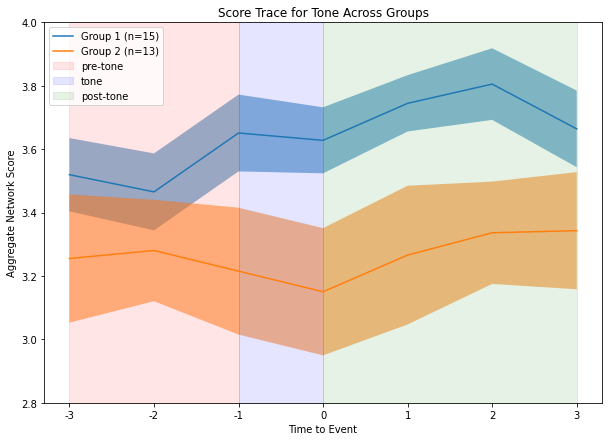

In [80]:
plt.figure(figsize=(10,7))
plt.plot(group_1_mean,label="Group 1 (n={})".format(group_1_mouse_mean_scores.shape[0]))
plt.plot(group_2_mean,label="Group 2 (n={})".format(group_2_mouse_mean_scores.shape[0]))
#plt.axvline(x=n_before,color="red",linestyle="dashed",alpha=0.7,label="Tone")
plt.fill_between(range(n_before + n_after),group_1_mean+group_1_stderr,group_1_mean-group_1_stderr,alpha=0.5)
plt.fill_between(range(n_before + n_after),group_2_mean+group_2_stderr,group_2_mean-group_2_stderr,alpha=0.5)
plt.fill_between(np.arange(n_before + n_after)[:n_before],2.8,4,alpha=0.1,color="red",label="pre-tone")
plt.fill_between(np.arange(n_before + n_after)[2:4],2.8,4,alpha=0.1,color="blue",label="tone")
plt.fill_between(np.arange(n_before + n_after)[n_before:],2.8,4,alpha=0.1,color="green",label="post-tone")

plt.xticks(np.arange(n_before + n_after),np.arange(n_before + n_after)-3)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.legend(loc="upper left")
plt.title("Score Trace for Tone Across Groups")
plt.ylim([2.8,4])
#plt.savefig(FIGURE_PATH + "FearConditioning_Tone_with_Freeze_vs_Tone_without_Freeze.svg")
plt.show()

In [79]:
both_group_ids = np.hstack((group_1_mouse_ids,group_2_mouse_ids)).astype(object)
both_group_mean_scores = np.vstack((group_1_mouse_mean_scores,group_2_mouse_mean_scores)).astype(object)
group_identifiers = np.hstack([[1 for i in group_1_mouse_ids],[2 for i in group_2_mouse_ids]]).astype(object)

final_array = np.hstack([both_group_ids.reshape(-1,1),group_identifiers.reshape(-1,1),both_group_mean_scores])
final_array

df = pd.DataFrame(final_array)
df.columns = ["mouse","group","-3","-2","-1","0","1","2","3"]
df.head()

df.to_csv(PROJECT_PATH + "fear_conditioning_tone_events.csv")

In [52]:
n_before = 3
n_after = 4

mouse_fwt_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    
    temp_fwt = y.squeeze()[mouse_mask==1]
    temp_scores = s_agg.squeeze()[mouse_mask==1]
    temp_time = y_time.squeeze()[mouse_mask==1]
    
    for idx, fwt in enumerate(temp_fwt):
        if (idx > n_before) and idx < (len(temp_fwt) - n_after):
            
            if np.sum(temp_fwt[idx:idx+n_after])==n_after and np.sum(temp_fwt[idx-n_before:idx])==0:
                fwt_seg = temp_fwt[idx-n_before:idx+n_after]
                score_seg = temp_scores[idx-n_before:idx+n_after]
                
                mouse_fwt_segs.append(fwt_seg)
                mouse_score_segs.append(score_seg)
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
                
scores_final = np.array(mouse_score_segs)
mouse_final = np.array(mouse_id)
idx_final = np.array(idx_id)
time_final = np.array(time_id)
        
mouse_mean_scores = []
for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mean,label="Tone + Freeze (n={})".format(mouse_mean_scores.shape[0]))
plt.plot(mean_tnf,label="Tone w/o Freeze (n={})".format(mouse_mean_scores_tnf.shape[0]))
plt.axvline(x=n_before,color="red",linestyle="dashed",alpha=0.7,label="Tone")
plt.fill_between(range(n_before + n_after),mean+stderr,mean-stderr,alpha=0.5)
plt.fill_between(range(n_before + n_after),mean_tnf+stderr_tnf,mean_tnf-stderr_tnf,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.legend(loc="upper left")
plt.title("Score Trace for Tone with and without Freezing")
plt.savefig(FIGURE_PATH + "FearConditioning_Tone_with_Freeze_vs_Tone_without_Freeze.svg")
plt.show()

In [53]:
n_before = 3
n_after = 4

mouse_tnf_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    
    temp_tnf = y_tnf.squeeze()[mouse_mask==1]
    temp_scores = s_agg.squeeze()[mouse_mask==1]
    temp_time = y_time.squeeze()[mouse_mask==1]
    
    for idx, tnf in enumerate(temp_tnf):
        if (idx > n_before) and idx < (len(temp_fwt) - n_after):
            
            if np.sum(temp_tnf[idx:idx+n_after])==n_after and np.sum(temp_tnf[idx-n_before:idx])==0:
                tnf_seg = temp_tnf[idx-n_before:idx+n_after]
                score_seg = temp_scores[idx-n_before:idx+n_after]
                
                mouse_tnf_segs.append(tnf_seg)
                mouse_score_segs.append(score_seg)
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
                
scores_final = np.array(mouse_score_segs)
mouse_final = np.array(mouse_id)
idx_final = np.array(idx_id)
time_final = np.array(time_id)
        
mouse_mean_scores_tnf = []
for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores_tnf.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores_tnf = np.array(mouse_mean_scores_tnf)
mean_tnf = np.mean(mouse_mean_scores_tnf,axis=0)
stderr_tnf = np.std(mouse_mean_scores_tnf,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    

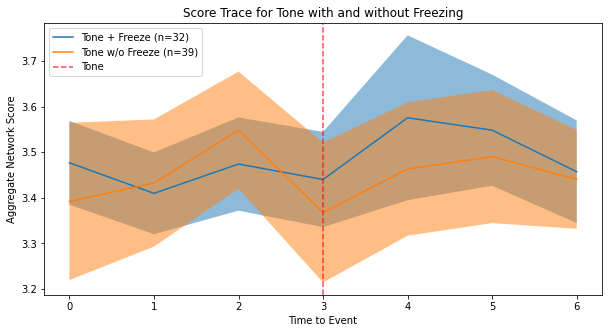

In [60]:
plt.figure(figsize=(10,5))
plt.plot(mean,label="Tone + Freeze (n={})".format(mouse_mean_scores.shape[0]))
plt.plot(mean_tnf,label="Tone w/o Freeze (n={})".format(mouse_mean_scores_tnf.shape[0]))
plt.axvline(x=n_before,color="red",linestyle="dashed",alpha=0.7,label="Tone")
plt.fill_between(range(n_before + n_after),mean+stderr,mean-stderr,alpha=0.5)
plt.fill_between(range(n_before + n_after),mean_tnf+stderr_tnf,mean_tnf-stderr_tnf,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.legend(loc="upper left")
plt.title("Score Trace for Tone with and without Freezing")
plt.savefig(FIGURE_PATH + "FearConditioning_Tone_with_Freeze_vs_Tone_without_Freeze.svg")
plt.show()

In [61]:
np.unique(y_mouse)

array(['Mouse04191', 'Mouse04193', 'Mouse04195', 'Mouse04201',
       'Mouse04202', 'Mouse04203', 'Mouse04205', 'Mouse04211',
       'Mouse04213', 'Mouse04214', 'Mouse04215', 'Mouse39111',
       'Mouse39113', 'Mouse39114', 'Mouse39115', 'Mouse39121',
       'Mouse39122', 'Mouse39124', 'Mouse39125', 'Mouse39132',
       'Mouse39133', 'Mouse39134', 'Mouse39135', 'Mouse9001', 'Mouse9002',
       'Mouse9003', 'Mouse9011', 'Mouse9013', 'Mouse9021', 'Mouse9022',
       'Mouse9061', 'Mouse9064', 'Mouse9065', 'Mouse9071', 'Mouse9072',
       'Mouse9074', 'Mouse9075', 'Mouse9081', 'Mouse9084'], dtype='<U10')

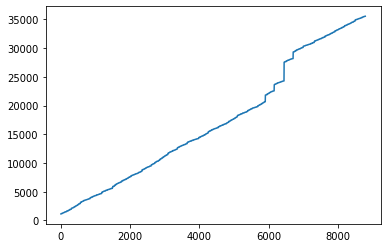

In [13]:
plt.plot(np.where(y==1)[0])

In [6]:
num_before = 3
num_after = 4

auc_list = []
mouse_list = []
mouse_snip_list = []
for file in scd_pickle_files:
    dictSC = pickle.load(open(DATA_PATH + file, "rb"))
    X = np.hstack([dictSC[key] for key in ["X_psd","X_coh","X_gc"]])
    y = dictSC["y_countDown"]
    s = model.project(X)
    coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
    s_agg = np.sum(s[:,:3] * coeffs,axis=1)
    mouse_auc = model.score(X,y.reshape(-1,1))
    print("{} AUC: {}".format(file.split("_")[0],mouse_auc))
    auc_list.append(mouse_auc)
    mouse_list.append(file.split("_")[0])
    

    mouse_snips = []
    mouse_ids = []
    for expDate in np.unique(dictSC["y_expDate_aw"]):

        expDate_mask = dictSC["y_expDate_aw"]==expDate
        expDate_pump_mask = np.logical_and(expDate_mask,dictSC["y_pump_allWindows"])
        pump_times = dictSC["y_time_aw"][expDate_pump_mask==1]

        expDate_mask_w = dictSC["y_expDate"]==expDate
        masked_time = dictSC["y_time"][expDate_mask_w==1]

        for pump_time in pump_times:
            pump_idx = np.where(masked_time==pump_time)[0].astype(int)
            if pump_idx.shape[0] < 1:
                continue
            else:
                pump_idx = pump_idx[0]


                if np.array_equal(np.arange(pump_time-num_before,pump_time+num_after),masked_time[pump_idx - num_before: pump_idx+num_after]):
                    mouse_snips.append(s_agg[pump_idx-num_before:pump_idx+num_after])


    mouse_mean_scores = np.mean(mouse_snips,axis=0).squeeze()
    mouse_snip_list.append(mouse_mean_scores)
    

dict_keys(['mouse', 'expDate', 'time'])

In [18]:
model.score(X,dataDict["y_freeze_w_tone"],dataDict["y_mouse"],return_dict=True)

{'Mouse04191': [nan],
 'Mouse04193': [0.4747637581813253],
 'Mouse04195': [0.4667827327711048],
 'Mouse04201': [0.39765839713388296],
 'Mouse04202': [0.5276233610914245],
 'Mouse04203': [0.5113183279742765],
 'Mouse04205': [0.5497835497835498],
 'Mouse04211': [0.5353698389925076],
 'Mouse04213': [0.531997183130079],
 'Mouse04214': [0.4855333158904587],
 'Mouse04215': [0.487664017990198],
 'Mouse39111': [0.48276707003992897],
 'Mouse39113': [0.46759600031707566],
 'Mouse39114': [0.46007380073800735],
 'Mouse39115': [0.46357661525414745],
 'Mouse39121': [0.4961997144536827],
 'Mouse39122': [0.4749336966699748],
 'Mouse39124': [0.5948742895181525],
 'Mouse39125': [0.5120510592519034],
 'Mouse39132': [0.510909573633588],
 'Mouse39133': [0.5447626301091647],
 'Mouse39134': [0.5771339224672727],
 'Mouse39135': [0.4598963775064764],
 'Mouse9001': [nan],
 'Mouse9002': [0.4878971173822715],
 'Mouse9003': [nan],
 'Mouse9011': [0.5257392307058727],
 'Mouse9013': [nan],
 'Mouse9021': [nan],
 'Mous